In [0]:
%matplotlib inline
%tensorflow_version 2.x

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
import numpy as np
import math
import typing
import tqdm
import os
import itertools
import copy
import subprocess
import sys

from pathlib import Path
from enum import IntEnum
from sklearn.decomposition import FastICA
from collections import Counter, defaultdict

np.random.seed(42)
tf.random.set_seed(231)

# save outputs of this notebook to data
# and read weights from data directory
os.chdir('data')

# Build a model according to specification (Tbl. 1 Higgins et al.)
* **Input**  4096 (flattened 64x64x1).
* **Encoder**  FC 1200, 1200. ReLU activation.
* **Latents**  10
* **Decoder**  FC 1200, 1200, 1200, 4096. Tanh activation. Bernoulli.
* **Optimiser** Adagrad 1e-2

In [0]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim=10):
        super(VAE, self).__init__()
        self._latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer((64, 64, 1)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1200, activation='relu'),
            tf.keras.layers.Dense(1200, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(latent_dim),
            tf.keras.layers.Dense(1200, activation='tanh'),
            tf.keras.layers.Dense(1200, activation='tanh'),
            tf.keras.layers.Dense(1200, activation='tanh'),
            tf.keras.layers.Dense(4096),
            tf.keras.layers.Reshape((64, 64, 1))
        ])

    def call(self, x): raise NotImplementedError

    def encode(self, x):
        h = self.encoder(x)
        mean, logvar = tf.split(h, num_or_size_splits=2, axis=1)
        return self.reparameterise(mean, logvar), mean, logvar
    
    def decode(self, z):
        return self.decoder(z)

    @staticmethod
    def reparameterise(mean, logvar):
        # log sig^2 = 2 log sig => exp(1/2 log sig^2) = exp(log sig) = sig
        eps = tf.random.normal(mean.shape, mean=0.0, stddev=1.0)
        return mean + tf.exp(logvar * 0.5) * eps

BETA = 4
EPOCHS = 100
LATENT_DIM = 10
BATCH_SIZE = 32
TR_SIZE = 550_000

In [0]:
class PCA:
    def __init__(self, latent_dim: int, ds: 'DSprites', subset: int=100_000):
        x = ds.subset(subset)
        self._width = x.shape[1]
        self._height = x.shape[2]
        self.mean = np.mean(x, axis=0)
        self._latent_dim = latent_dim
        self._D = self._width * self._height
        x = (x - self.mean).reshape(-1, self._D)
        self._e, V = tf.linalg.eigh(tf.matmul(x.T, x))
        assert V.shape == (self._D, self._D)
        # non-decreasing => take the last latent_dim cols!
        self.V_k = V[:, -self._latent_dim:]
    
    def encode(self, x):
        x = (x - self.mean).reshape(-1, self._D)
        z = tf.matmul(x, self.V_k)
        assert z.shape == (x.shape[0], self._latent_dim)
        # our VAE encoders return z, mean, logvar
        # and our data generator takes the mean (see generate_benchmarking_dataset)
        # so we have to return z in the middle of a 3-tuple
        return z, z, None
    
    def decode(self, z):
        return tf.matmul(z, self.V_k, transpose_b=True).numpy().reshape(-1, self._width, self._height, 1) # + self.mean

    @property
    def explained_variance_ratio(self):
        e = self._e.numpy()[::-1]       
        return e[: self._latent_dim]/sum(e)

class ICA:
    def __init__(self, latent_dim: int, ds: 'DSprites', subset: int=100_000):
        x = ds.subset(subset)
        self._width = x.shape[1]
        self._height = x.shape[2]
        self._D = self._width * self._height
        self._model = FastICA(n_components=latent_dim)
        self._model.fit(x.reshape(-1, self._D))

    def encode(self, x):
        z = self._model.transform(x.reshape(-1, self._D))
        return z, z, None

    def decode(self, z):
        return self._model.inverse_transform(z).reshape(-1, self._width, self._height, 1)

In [0]:
class DSprites:
    class Latents(IntEnum):
        COLOUR, SHAPE, SCALE, ORIENTATION, XPOS, YPOS = range(6)
        
    """
    A significant portion of this class is taken as-is from the manual
    https://github.com/deepmind/dsprites-dataset/blob/master/dsprites_reloading_example.ipynb
    """
    def __init__(self, path=".", download=False):
        self._filename = 'dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
        path = Path(path).absolute()
        assert path.exists()
        data = path / self._filename
        if not data.exists():
            if download:
                subprocess.run(["wget", "-O", str(data),
                                "https://github.com/deepmind/dsprites-dataset/raw/master/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"])
            else:
                raise ValueException("Can't find dataset, use download=True to download.")
        data = np.load(str(data), encoding='bytes', allow_pickle=True)

        # ====

        imgs = data['imgs']
        metadata_raw = data['metadata'][()]
        self._metadata = dict()
        for k, v in metadata_raw.items():
            self._metadata[k.decode()] = v

        # NOTE: can't cast now because our notebook runs out of RAM. cast in map instead
        # imgs = imgs.reshape(-1, 64, 64, 1).astype(np.float32)
        self._imgs = imgs.reshape(-1, 64, 64, 1)

        # for example: array([ 0,  0,  2, 37, 15, 22])
        # i.e. the relative (normalised) change in latent factors
        self._latents_classes = data['latents_classes']

        # for example: array([1., 1., 0.7 , 5.96097068, 0.48387097, 0.70967742])
        # i.e. the actual latent values used to generate the image
        self._latents_values = data['latents_values']

        # specification: the number of varying "degrees" of change in each
        # dimension corresponding to an independent generative factor
        # array([ 1,        3,      6,           40,  32,  32])
        #       colour, shape,  scale,  orientation,   X,   Y
        self._latents_sizes = self._metadata['latents_sizes']

        # for easy conversion from latent vector to indices later (see latent_to_idx)
        # essentially: array([737280, 245760,  40960,   1024,     32,      1])
        self._latents_bases = np.r_[self._latents_sizes[::-1].cumprod()[::-1][1:], 1]
    
    def latent_size(self, latent: 'DSprites.Latents') -> int:
        """
        :param latent: of type DSprites.Latents (an enum class)
        :return: the maximum integer allowed for the specified `latent`
        """
        return self._latents_sizes[latent.value]
    
    def to_idx(self, latents: np.array) -> int:
        """
        convert latent vector into index that can then be used to index
        the actual image in self._imgs
        """
        return np.dot(latents, self._latents_bases).astype(int)
    
    def sample_latent(self, n: int=1, fixed: 'DSprites.Latents'=None) -> np.array:
        """
        randomly samples `n` latent vectors

        :param n: number samples
        :param fixed: if not `None`, then in all samples, this latent is kept
                     fixed based on a random draw. The rest of the latents are
                     random.
        :return: an `np.array` of shape nx6
        """
        samples = np.zeros((n, self._latents_sizes.shape[0]))
        for i, lat_size in enumerate(self._latents_sizes):
            samples[:, i] = np.random.randint(lat_size, size=n)
        if fixed:
            samples[:, fixed] = np.random.randint(0, ds.latent_size(fixed))
        return samples
    
    @property
    def imgs(self) -> np.array:
        return self._imgs

    def subset(self, size=50_000) -> np.array:
        """
        returns a subset of the images. (Workaround for memory constraints)
        :param size: number of samples to return
        """
        return self._imgs[np.random.choice(self._imgs.shape[0], size=size, replace=False)]

def make_grid(tensor: np.array, nrow: int=8, padding: int=2, pad_value: int=0) -> np.array:
    """
    adapted from: https://pytorch.org/docs/stable/_modules/torchvision/utils.html#make_grid
    :param tensor: nxwxhxc np.array
    :param nrow: number of images displayed in each row
    :param padding: padding between images
    :param pad_value: value used to pad
    :return: np.array of dimension 3 (WxHxC) with all images arranged in a grid.

    """
    if tensor.shape[0] == 1:
        return tensor.squeeze()

    # make the mini-batch of images into a grid
    nmaps = tensor.shape[0]
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height, width = int(tensor.shape[1] + padding), int(tensor.shape[2] + padding)
    num_channels = tensor.shape[3]
    grid = np.full((height * ymaps + padding, width * xmaps + padding, num_channels), pad_value, dtype=tensor.dtype)
    k = 0
    for y in range(ymaps):
        for x in range(xmaps):
            if k >= nmaps: break
            ystart = y * height + padding
            xstart = x * width + padding
            grid[ystart:(ystart + height - padding), ...][:, xstart:(xstart + width - padding), :] = tensor[k]
            k = k + 1
    return grid.squeeze()

def imshow(img: np.array, title: str='', ax: plt.Axes=None):
    if not ax:
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray', interpolation='nearest')
    ax.set_xticks(())
    ax.set_yticks(())
    if title:
        ax.set_title(title)

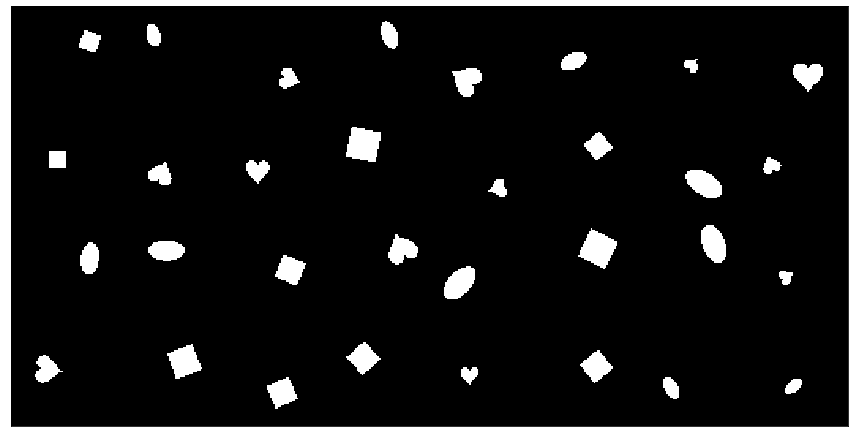

In [0]:
ds = DSprites(download=True)
test_batch = ds.subset(size=32)
imshow(make_grid(test_batch))

[0.11633517 0.11538306 0.07834267 0.0776974  0.06081044 0.04128697
 0.04092293 0.02613099 0.02589801 0.02560921]
0.6084168524057268


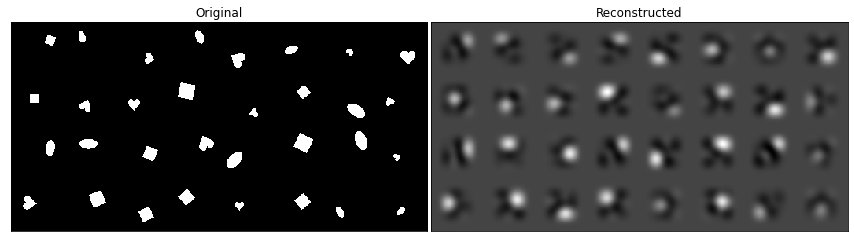

In [0]:
pca = PCA(LATENT_DIM, ds, subset=75_000)
print(pca.explained_variance_ratio)
print(sum(pca.explained_variance_ratio))

# simple sanity check
z, *_ = pca.encode(test_batch)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
imshow(make_grid(test_batch), title='Original', ax=ax1)
imshow(make_grid(pca.decode(z)), title='Reconstructed', ax=ax2)
fig.subplots_adjust(wspace=0.01)
plt.show()


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f28b28c0f98> and <tensorflow.python.keras.layers.core.Dense object at 0x7f28b286d1d0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f28b286d1d0> and <tensorflow.python.keras.layers.core.Dense object at 0x7f28b286d438>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f28b202c240> and <tensorflow.python.keras.layers.core.Dense object at 0x7f28b2036860>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f28b2036860> and <tensorflow.python.keras.layers.core.Dense object at 0x7f28b2036c88>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f28b2036c88> and <tensorflow.python.keras.layers.core.Dense object at 0x7f28b2

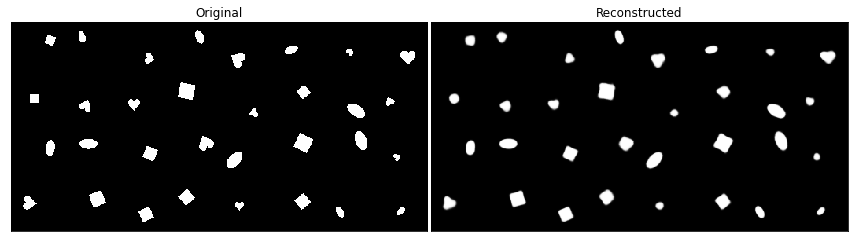

In [0]:
vae4 = VAE(LATENT_DIM)
# load pretrained model with 100 epochs (from 550k randomly sampled points)
vae4.load_weights(f'./vae4/vae4_e100_550000')

z, *_ = vae4.encode(test_batch)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
imshow(make_grid(test_batch), title='Original', ax=ax1)
imshow(make_grid(tf.nn.sigmoid(vae4.decode(z)).numpy()), title='Reconstructed', ax=ax2)
fig.subplots_adjust(wspace=0.01)
plt.show()


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f26ee5bacc0> and <tensorflow.python.keras.layers.core.Dense object at 0x7f26ee5c10f0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f26ee5c10f0> and <tensorflow.python.keras.layers.core.Dense object at 0x7f26ee5c1390>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f26ee550a20> and <tensorflow.python.keras.layers.core.Dense object at 0x7f26ee55b3c8>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f26ee55b3c8> and <tensorflow.python.keras.layers.core.Dense object at 0x7f26ee55b7f0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f26ee55b7f0> and <tensorflow.python.keras.layers.core.Dense object at 0x7f26ee

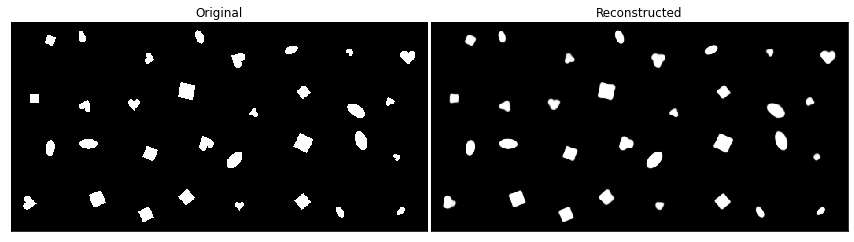

In [0]:
vae1 = VAE(LATENT_DIM)
# load pretrained model with 100 epochs (from 550k randomly sampled points)
vae1.load_weights(f'./vae1/vae1_e100_550000')

# simple sanity check
z, *_ = vae1.encode(test_batch)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
imshow(make_grid(test_batch), title='Original', ax=ax1)
imshow(make_grid(tf.nn.sigmoid(vae1.decode(z)).numpy()), title='Reconstructed', ax=ax2)
fig.subplots_adjust(wspace=0.01)
plt.show()

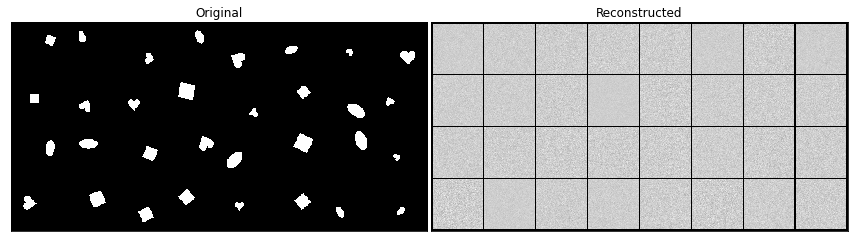

In [0]:
vae_untrained = VAE(LATENT_DIM)

z, *_ = vae_untrained.encode(test_batch)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
imshow(make_grid(test_batch), title='Original', ax=ax1)
imshow(make_grid(tf.nn.sigmoid(vae_untrained.decode(z)).numpy()), title='Reconstructed', ax=ax2)
fig.subplots_adjust(wspace=0.01)
plt.show()

# Generating datapoints

todo

In [0]:
def generate_benchmarking_dataset(model: VAE,
                                  ds: DSprites, l: int,
                                  batches: int,
                                  with_shapes: bool=False) -> typing.Tuple[np.array, np.array]:
    """
    :param model: must have an `encode` function that takes a tensor of shape
                  N x W x H x C and returns a tuple (z, mean, logvar)
                  where all three elements are of shape N x LATENT_DIM
    :param ds: DSprites dataset                 
    :param l: number of samples to draw for a given fixed latent.
    :param batches: number of training points. 
    :param with_shapes: should shapes be included as a fixed latent or ignored?
    :return: a tuple of x and y where x & y are arrays of length `batches`
    """                                
    x = []
    y = []

    subset = ds.subset(size=50_000)
    z_subset, mean_subset, _ = model.encode(subset)
    # Locatello et al. 2019 used 0.05 as the threshold whilst Kim et al. 2018
    # only mentioned that the collpsed latent dimensions are pruned.
    # this is a pretty good approximation
    subset_features = np.var(mean_subset, axis=0) >= 0.05
    print(f"INFO: {sum(subset_features)}/{subset_features.shape[0]} dimensions used.", file=sys.stderr)
    if sum(subset_features) == 0:
        subset_features = np.array([True] * mean_subset.shape[-1])
        print(f"WARNING: Using all {subset_features.shape[0]} latents since none are viable.", file=sys.stderr)

    # calculate the empirical std dev of the whole dataset;
    # approximated with 50,000 samples instead
    empirical_stddev = np.std(z_subset, axis=0)

    # here, each batch is allowed to fix a different latent factor
    for b in tqdm.trange(batches):
        # low=2 because 0 is COLOUR which is always fixed and 1 is SHAPE
        # but the paper doesn't evaluate SHAPEs
        least_latent_idx = 1 if with_shapes else 2
        y_fixed = DSprites.Latents(
            np.random.randint(low=least_latent_idx, high=6, size=1)
        )
        assert y_fixed != DSprites.Latents.COLOUR and (with_shapes or y_fixed != DSprites.Latents.SHAPE)

        z, *_ = model.encode(
            ds.imgs[ds.to_idx(ds.sample_latent(n=l, fixed=y_fixed))]
        )

        # take the variance of the normalised representation
        # then prune unused dimensions according to the filter defined above
        z_var = np.var(z / empirical_stddev, axis=0)[subset_features]

        x.append(np.argmin(z_var, axis=0))

        assert y_fixed.value >= least_latent_idx
        # the integers are expected to start from 0 but we start from low=least_latent_idx
        # hence, we have to shift it.
        y.append(y_fixed.value - least_latent_idx)
    return np.array(x), np.array(y)

# Quantitative measure: Majority-vote classifer

todo

In [0]:
def get_majority_vote_classifer(x, y):
    """
    :param x: array of length `N`
    :param y: array of length `N`
    """
    class MVClassifier:
        def __init__(self, x, y):
            counts = Counter(list(zip(x, y)))
            tally = defaultdict(int)
            tbl = {}
            for (idx, target), votes in counts.items():
                # if another target has the majority votes, switch target
                if votes > tally[idx]:
                    tally[idx] = votes
                    tbl[idx] = target
            self._tbl = tbl

        def evaluate(self, x, y):
            # returns accuracy
            return np.mean(self.predict(x) == y)
        
        def predict(self, x):
            return np.array([self._tbl[idx] for idx in x])
    return MVClassifier(x, y)               

In [0]:
# how many times to repeat the experiment. Each repetition creates a
# new linear classifier with different initial values
# repeat once since our classifier has no stochasticity
REPEAT = 1
# in each batch, we take the average of L zdiffs
L = 64
# take B batches, i.e. creating a dataset of size (B, LATENT_DIM)
B = 10_000
# section 4.2: The table in Fig. 6 (left) reports the classification accuracy of the disentanglement metric for 5,000 test samples
E = 5_000

In [0]:
def run_experiment(model: VAE, ds: DSprites, l: int, batches: int, test_batch: int,
                   reps: int, with_shapes: bool=False, 
                   latent_subset: typing.Optional[typing.List[int]]=None) -> np.array:
    """
    :param model: must have an `encode` function that takes a tensor of shape
                  N x W x H x C and returns a tuple (z, mean, logvar)
                  where all three elements are of shape N x LATENT_DIM
    :param ds: DSprites object used to generate dataset                 
    :param l: number of samples to draw for a given fixed latent. Corresponds
              to the same L described in the paper.
    :param batches: number of batches. Corresponds to the same B
                    described in the paper.
    :param test_batch: number of test batch. The paper used 5,000 test points
                       to evulate the accuracy of the linear classifier.                   
    :param reps: number of times to repeat this experiment.
    :param with_shapes: should shapes be included as a latent factor that should
                        be measured?
    :param latent_subset: If none, all `LATENT_DIM` dimensions are used. Otherwise,
                          will use the provided list to index the subset of
                          dimensions desired: `z[:, latent_subset]`.
    :return: an np.array of accuracies. This array is of length `reps`, where
             each element corresponds to the maximum accuracy
             obtained during training for that particular iteration.
    """
    # create data (z^b_diff)s
    x_train, y_train = generate_benchmarking_dataset(model, ds,
                                                     l=l, batches=(batches + test_batch),
                                                     with_shapes=with_shapes)
    if latent_subset:
        x_train = x_train[:, latent_subset]                                                    
    x_train = x_train[: batches]
    y_train = y_train[: batches]
    x_test = x_train[-test_batch:]
    y_test = y_train[-test_batch:]

    assert y_train.shape == (B, )
    assert y_test.shape == (E, )
    assert ((y_train < (5 if with_shapes else 4)) & (y_train >= 0)).all()
    assert ((y_test < (5 if with_shapes else 4)) & (y_test >= 0)).all()
    
    # show target class distribution
    counts = dict(zip(*np.unique(y_train, return_counts=True)))
    plt.bar([DSprites.Latents(k + (1 if with_shapes else 2)).name for k in counts.keys()], counts.values())
    plt.title(f"Distribution of fixed latents in {B:,} samples.")
    print(counts)

    accuracies = []
    for r in range(1, reps + 1):
        linear_classifier = get_majority_vote_classifer(x_train, y_train)
        accuracies.append(linear_classifier.evaluate(x_test, y_test))
    return np.array(accuracies)

## Evaluating $\beta$-VAE's quantitative performance ($\beta$ = 4)

INFO: 5/10 dimensions used.
100%|██████████| 15000/15000 [00:44<00:00, 336.21it/s]


{0: 2469, 1: 2521, 2: 2499, 3: 2511}


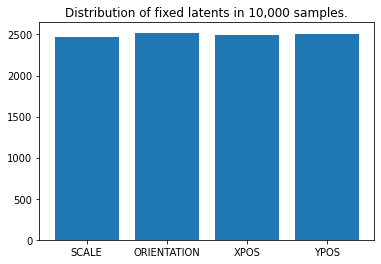

In [0]:
vae4_accs = run_experiment(vae4, ds, l=L, batches=B, test_batch=E, reps=REPEAT, with_shapes=False)

## Evaluating VAE's quantitative performance ($\beta$ = 1)

INFO: 5/10 dimensions used.
100%|██████████| 15000/15000 [00:45<00:00, 332.73it/s]


{0: 2518, 1: 2470, 2: 2508, 3: 2504}


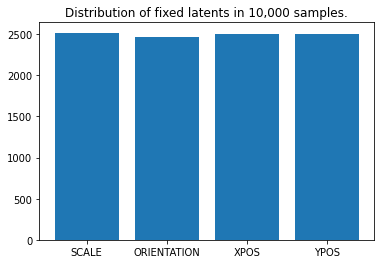

In [0]:
vae1_accs = run_experiment(vae1, ds, l=L, batches=B, test_batch=E, reps=REPEAT, with_shapes=False)

## Evaluating untrained VAE's quantitative performance

INFO: 0/10 dimensions used.
100%|██████████| 15000/15000 [00:45<00:00, 332.26it/s]


{0: 2471, 1: 2478, 2: 2551, 3: 2500}


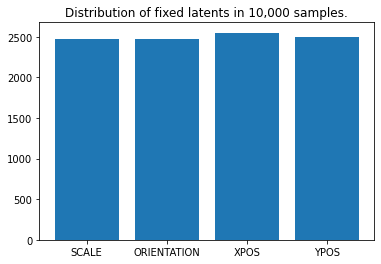

In [0]:
vaeu_accs = run_experiment(vae_untrained, ds, l=L, batches=B, test_batch=E, reps=REPEAT, with_shapes=False)

## Evaluating PCA's quantitative performance

INFO: 10/10 dimensions used.
100%|██████████| 15000/15000 [00:30<00:00, 494.08it/s]


{0: 2446, 1: 2457, 2: 2573, 3: 2524}


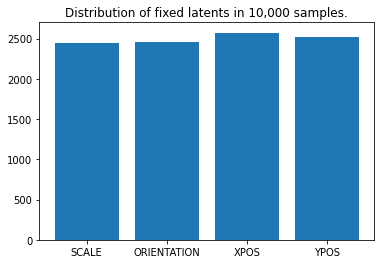

In [0]:
pca_accs= run_experiment(pca, ds, l=L, batches=B, test_batch=E, reps=REPEAT, with_shapes=False)

In [0]:
print(vae4_accs)
print(vae1_accs)
print(vaeu_accs)
print(pca_accs)

print(np.mean(vae4_accs), np.std(vae4_accs))
print(np.mean(vae1_accs), np.std(vae1_accs))
print(np.mean(vaeu_accs), np.std(vaeu_accs))
print(np.mean(pca_accs), np.std(pca_accs))

[0.9582]
[0.5878]
[0.2706]
[0.6376]
0.9582 0.0
0.5878 0.0
0.2706 0.0
0.6376 0.0


# Note, we will NOT be using 0.95 here as the reported accuracy. We will be using the one below instead (where all $\beta$ = 0.5...10 are evaluated).

## Evaluating $\beta$-VAE's quantitative performance ($\beta$ = 4) with shapes included

INFO: 5/10 dimensions used.
100%|██████████| 15000/15000 [00:44<00:00, 334.01it/s]


{0: 2021, 1: 2007, 2: 2075, 3: 1910, 4: 1987}


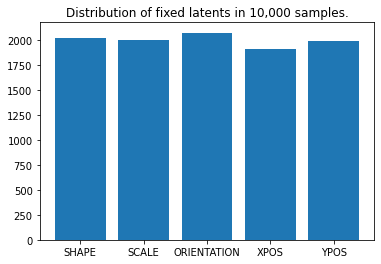

In [0]:
vae4_accs_shapes = run_experiment(vae4, ds, l=L, batches=B, test_batch=E, reps=REPEAT, with_shapes=True)

## Evaluating VAE's quantitative performance ($\beta$ = 1) with shapes included

INFO: 5/10 dimensions used.
100%|██████████| 15000/15000 [00:44<00:00, 333.38it/s]


{0: 1955, 1: 1989, 2: 2022, 3: 1975, 4: 2059}


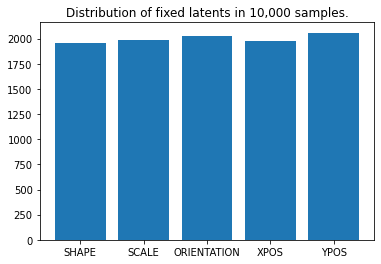

In [0]:
vae1_accs_shapes = run_experiment(vae1, ds, l=L, batches=B, test_batch=E, reps=REPEAT, with_shapes=True)

## Evaluating untrained VAE's quantitative performance with shapes included

INFO: 0/10 dimensions used.
100%|██████████| 15000/15000 [00:44<00:00, 336.08it/s]


{0: 1942, 1: 1993, 2: 2034, 3: 1989, 4: 2042}


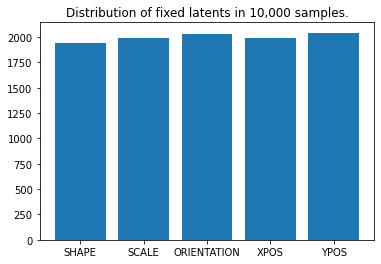

In [0]:
vaeu_accs_shapes = run_experiment(vae_untrained, ds, l=L, batches=B, test_batch=E, reps=REPEAT, with_shapes=True)

## Evaluating PCA's quantitative with shapes included

INFO: 10/10 dimensions used.
100%|██████████| 15000/15000 [00:29<00:00, 513.01it/s]


{0: 1965, 1: 2025, 2: 1949, 3: 2021, 4: 2040}


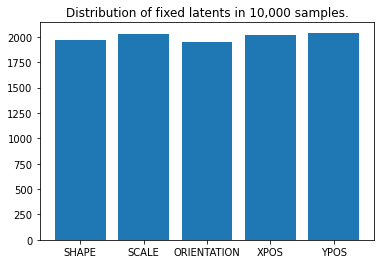

In [0]:
pca_accs_shapes = run_experiment(pca, ds, l=L, batches=B, test_batch=E, reps=REPEAT, with_shapes=True)

In [0]:
print(vae4_accs_shapes)
print(vae1_accs_shapes)
print(vaeu_accs_shapes)
print(pca_accs_shapes)

print(np.mean(vae4_accs_shapes), np.std(vae4_accs_shapes))
print(np.mean(vae1_accs_shapes), np.std(vae1_accs_shapes))
print(np.mean(vaeu_accs_shapes), np.std(vaeu_accs_shapes))
print(np.mean(pca_accs_shapes), np.std(pca_accs_shapes))

[0.7596]
[0.4768]
[0.218]
[0.5094]
0.7596 0.0
0.4768 0.0
0.218 0.0
0.5094 0.0


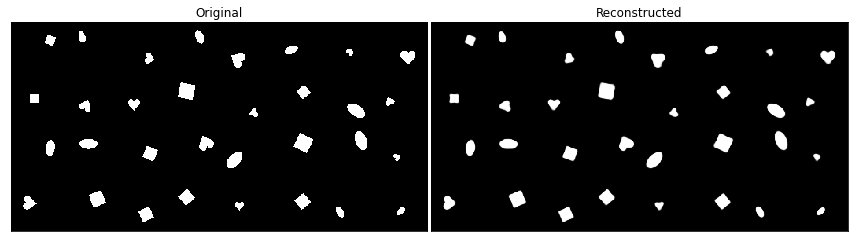

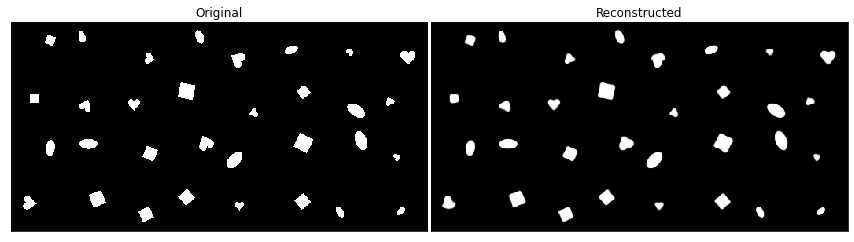

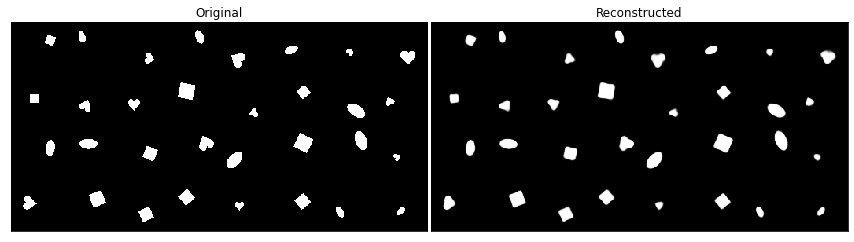

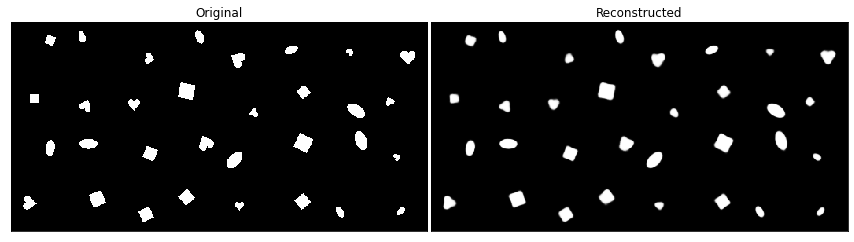

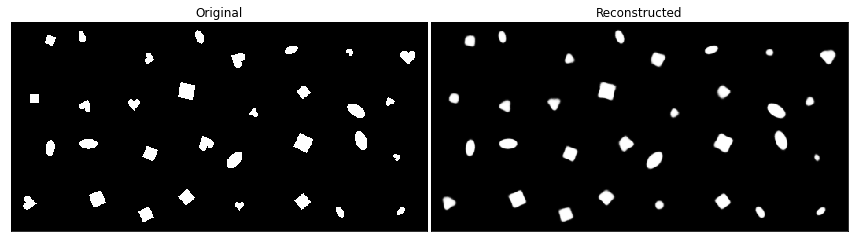

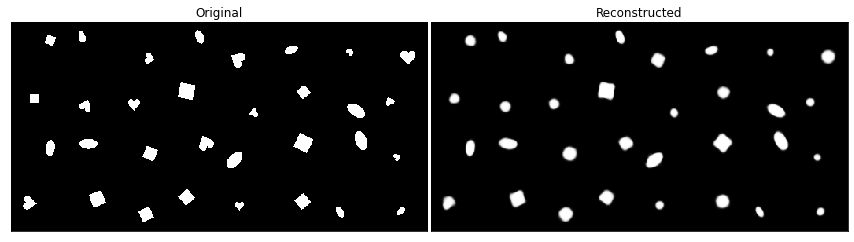

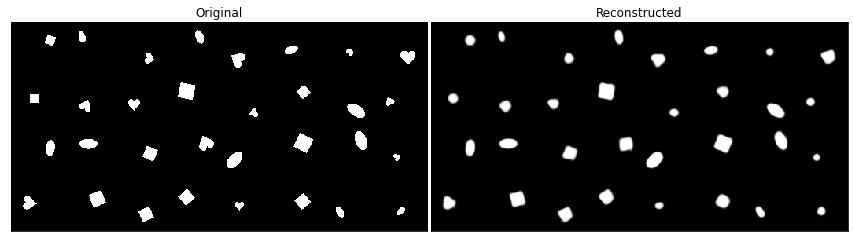

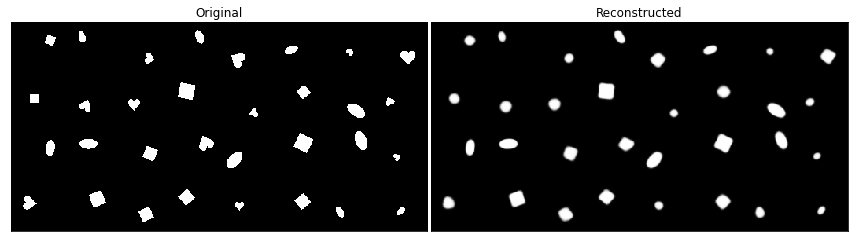

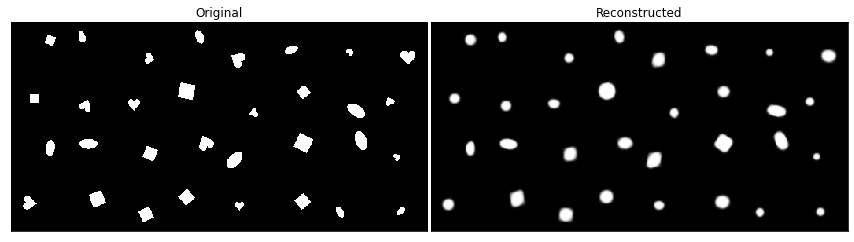

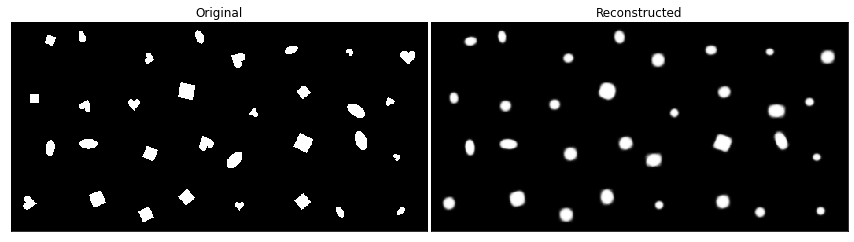

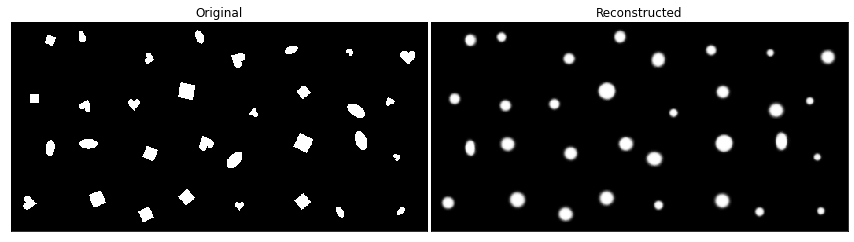

In [0]:
model_name = "vae{}_weights_100e_550ktr.h5"
vaes = []

for i in (["0.5"] + [str(i) for i in range(1, 11)]):
    vae = VAE(LATENT_DIM)
    # load pretrained model with 100 epochs (from 550k randomly sampled points)
    vae.load_weights(model_name.format(i))
    vaes.append(vae)
    # simple sanity check
    z, *_ = vae.encode(test_batch)
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    imshow(make_grid(test_batch), title='Original', ax=ax1)
    imshow(make_grid(tf.nn.sigmoid(vae.decode(z)).numpy()), title='Reconstructed', ax=ax2)
    fig.subplots_adjust(wspace=0.01)
    plt.show()

INFO: 6/10 dimensions used.
100%|██████████| 15000/15000 [00:43<00:00, 341.71it/s]


{0: 2501, 1: 2424, 2: 2529, 3: 2546}


INFO: 6/10 dimensions used.
100%|██████████| 15000/15000 [00:44<00:00, 339.74it/s]


{0: 2411, 1: 2574, 2: 2469, 3: 2546}


INFO: 5/10 dimensions used.
100%|██████████| 15000/15000 [00:43<00:00, 346.44it/s]


{0: 2448, 1: 2536, 2: 2526, 3: 2490}


INFO: 5/10 dimensions used.
100%|██████████| 15000/15000 [00:43<00:00, 348.64it/s]


{0: 2470, 1: 2501, 2: 2539, 3: 2490}


INFO: 5/10 dimensions used.
100%|██████████| 15000/15000 [00:42<00:00, 349.56it/s]


{0: 2468, 1: 2473, 2: 2508, 3: 2551}


INFO: 4/10 dimensions used.
100%|██████████| 15000/15000 [00:42<00:00, 352.58it/s]


{0: 2538, 1: 2461, 2: 2533, 3: 2468}


INFO: 5/10 dimensions used.
100%|██████████| 15000/15000 [00:42<00:00, 350.78it/s]


{0: 2494, 1: 2420, 2: 2598, 3: 2488}


INFO: 5/10 dimensions used.
100%|██████████| 15000/15000 [00:43<00:00, 344.42it/s]


{0: 2549, 1: 2497, 2: 2377, 3: 2577}


INFO: 4/10 dimensions used.
100%|██████████| 15000/15000 [00:42<00:00, 350.82it/s]


{0: 2550, 1: 2476, 2: 2564, 3: 2410}


INFO: 4/10 dimensions used.
100%|██████████| 15000/15000 [00:42<00:00, 352.15it/s]


{0: 2473, 1: 2559, 2: 2551, 3: 2417}


INFO: 3/10 dimensions used.
100%|██████████| 15000/15000 [00:42<00:00, 355.62it/s]


{0: 2473, 1: 2496, 2: 2483, 3: 2548}
[0.5452 0.6474 0.573  0.927  0.9802 0.692  0.9424 0.9966 0.9098 0.912
 0.7528]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


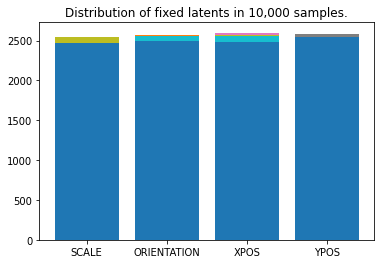

In [0]:
accs = []
for vae in vaes:
    accs.append(run_experiment(vae, ds, l=L, batches=B, test_batch=E, reps=REPEAT, with_shapes=False))

# 11x3 matrix
accs = np.array(accs)
print(np.mean(accs, axis=1))
print(np.std(accs, axis=1))

In [0]:
np.save("factor_distentanglement_scores.npy", accs)
accs

array([[0.5452],
       [0.6474],
       [0.573 ],
       [0.927 ],
       [0.9802],
       [0.692 ],
       [0.9424],
       [0.9966],
       [0.9098],
       [0.912 ],
       [0.7528]])

In [0]:
factor_accs = accs
beta_accs = np.load("beta_accs.npy")

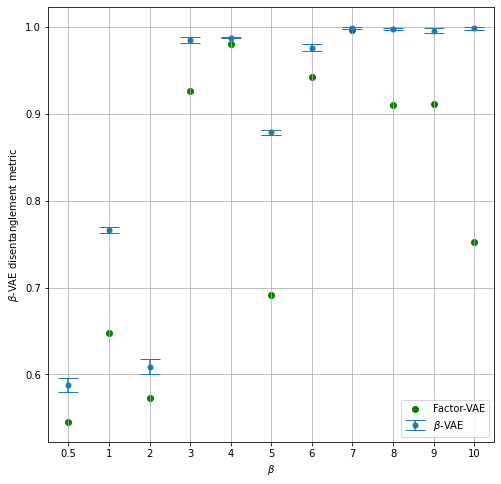

In [0]:
# plot 2-stddev to show 95% confidence
fig = plt.figure(num=1, figsize=(8, 8))
_, caps, _ = plt.errorbar(x=range(11),
                          y=np.mean(beta_accs, axis=1), yerr=(np.std(beta_accs, axis=1)*2),
                          fmt='o', markersize=5, capsize=10, label=r"$\beta$-VAE")
for cap in caps:
    cap.set_markeredgewidth(1)

plt.scatter(x=range(11), y=factor_accs, label="Factor-VAE", c='green')

plt.xticks(range(11), [0.5] + list(range(1, 11)))
plt.xlabel(r"$\beta$")
plt.ylabel("Disentanglement score");
plt.grid()
plt.legend(loc='lower right');
plt.savefig("beta_search_w_metric_comparison.pdf")

# Is $\beta$ = 5 truly that bad?

Repeat the same experiment for 5 independently trained ($\beta = 5$)-VAE.

INFO: 5/10 dimensions used.
100%|██████████| 15000/15000 [00:55<00:00, 270.55it/s]


{0: 2522, 1: 2504, 2: 2511, 3: 2463}


INFO: 5/10 dimensions used.
100%|██████████| 15000/15000 [00:54<00:00, 275.53it/s]


{0: 2540, 1: 2515, 2: 2470, 3: 2475}


INFO: 5/10 dimensions used.
100%|██████████| 15000/15000 [00:53<00:00, 278.37it/s]
INFO: 5/10 dimensions used.

{0: 2466, 1: 2520, 2: 2567, 3: 2447}



100%|██████████| 15000/15000 [00:53<00:00, 281.71it/s]


{0: 2421, 1: 2514, 2: 2571, 3: 2494}


INFO: 5/10 dimensions used.
100%|██████████| 15000/15000 [00:52<00:00, 284.38it/s]


{0: 2515, 1: 2497, 2: 2441, 3: 2547}
[0.995  0.7454 0.5392 0.9404 0.9672]
[0. 0. 0. 0. 0.]


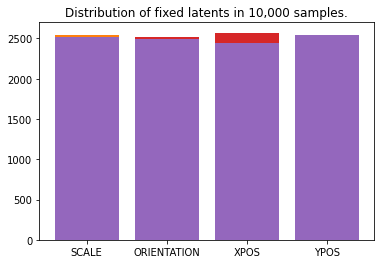

In [0]:
model_name = "vae5_rep_{}_weights_0-100e_550ktr_rep_2.h5"
vaes = []

for i in range(1, 6):
    vae = VAE(LATENT_DIM)
    vae.load_weights(model_name.format(i))
    vaes.append(vae)

accs = []
for vae in vaes:
    accs.append(run_experiment(vae, ds, l=L, batches=B, test_batch=E, reps=REPEAT, with_shapes=False))

# 5x3 matrix
accs = np.array(accs)
print(np.mean(accs, axis=1))
print(np.std(accs, axis=1))

# Visualising the representations of $\beta$ = 5 and 10, since they're both low on either Factor-VAE or both

Note that Factor-VAE's metric pruned 6 latents for $\beta = 5$ and 7 latents for $\beta = 10$. This implies that $\beta = 5$ only had 4 latents encoding 5 generative factors (likewise only 3 for $\beta = 10$).

In [0]:
SAMPLE_SIZE = 500
sample_latents = ds.sample_latent(SAMPLE_SIZE)

def pos_latent_heatmap(model, sample_latents, dim):
    lats = sample_latents.copy()
    heatmap = np.full(
        (ds.latent_size(DSprites.Latents.YPOS),
         ds.latent_size(DSprites.Latents.XPOS)),
        0, dtype=np.float32
    )
    for x in range(ds.latent_size(DSprites.Latents.XPOS)):
        lats[:, DSprites.Latents.XPOS] = x
        for y in range(ds.latent_size(DSprites.Latents.YPOS)):
            lats[:, DSprites.Latents.YPOS] = y
            z, mean, logvar = model.encode(ds.imgs[ds.to_idx(lats)])
            z = z.numpy()
            # notice how it's [y, x] since the rows represent the y-axis
            heatmap[y, x] = np.mean(z[:, dim])
    return heatmap

def latent_activations(latent: DSprites.Latents, model, sample_latents, dim):
    lats = sample_latents.copy()
    square_idxs = lats[:, DSprites.Latents.SHAPE] == 0
    oval_idxs = lats[:, DSprites.Latents.SHAPE] == 1
    heart_idxs = lats[:, DSprites.Latents.SHAPE] == 2
    assert (square_idxs | oval_idxs | heart_idxs).all()
    scales = {'square': [], 'oval': [], 'heart': []}
    for l in range(ds.latent_size(latent)):
        lats[:, latent] = l
        z, mean, logvar = model.encode(ds.imgs[ds.to_idx(lats)])
        z = z.numpy()
        scales['square'].append(np.mean(z[square_idxs, dim]))
        scales['oval'].append(np.mean(z[oval_idxs, dim]))
        scales['heart'].append(np.mean(z[heart_idxs, dim]))
    return scales

def latent_shape_activations(model, sample_latents, dim):
    lats = sample_latents.copy()
    shapes = [[], [], []]
    for l in range(ds.latent_size(DSprites.Latents.SHAPE)):
        lats[:, DSprites.Latents.SHAPE] = l
        z, mean, logvar = model.encode(ds.imgs[ds.to_idx(lats)])
        z = z.numpy()
        shapes[l] = z[:, dim]
    return {'square': shapes[0], 'oval': shapes[1], 'heart': shapes[2]}


def vary_latent(seed_img, model: VAE, dim: int,
                zmin: float=-2, zmax: float=2, step: float=1,
                activation: typing.Callable[[tf.Tensor], tf.Tensor]=None) -> np.array:
    """
    :param seed_img: image used as seed when varying latents. This image
                     will be encoded by `model.encode(seed_img)` and the
                     resulting `z` latent vector will be varied. Should be
                     of shape (B, W, H, C).
    :param model: VAE model used to encode and decode latents                     
    :param dim: the dimension to vary. This value must be 0 <= dim < LATENT_DIM
    :param zmin: determines the range of `z` to vary. `z` is varied starting from
    `z[dim] + zmin` to `z[dim] + zmax`. Must be a negative value.
    :param zmax: determines the range of `z` to vary. `z` is varied starting from
    `z[dim] + zmin` to `z[dim] + zmax`. Must be a positive value.
    :param step: the step size used to increment `z` when varying `z[dim]`.
    :param activation: activation function to apply on
                       `activation(model.decode(z))`. None applied if `None`
                       (default).
    :return: a numpy array of shape (N, B, W, H, C) where:
              - N: number of total images generated when varying `z` according
                   to `zmin`, `zmax`, `step`.
                   That is, N = 1 + abs(zmax - zmin) // step
              - B: batch size. This is the same as `seed_img.shape[0]`
              - W: image width. This is the same as `seed_img.shape[1]`
              - H: image height. This is the same as `seed_img.shape[2]`
              - C: image channel. This is the same as `seed_img.shape[3]`
    """
    assert zmin < 0 and zmax > 0
    if not activation:
        activation = lambda x: x
    z, *_ = model.encode(seed_img)
    z = z.numpy()
    z[:, dim] += zmin
    reconstructed = []
    reconstructed.append(activation(model.decode(z)))
    for _ in range(int(abs(zmax - zmin) // step)):
        z[:, dim] += step
        reconstructed.append(activation(model.decode(z)))
    reconstructed = np.flip(np.array(reconstructed), axis=0)
    return reconstructed

def show_latents(model, dims: list, ds: DSprites,
                 reconstruction_activation_function: typing.Callable[[tf.Tensor], tf.Tensor]=None,
                 save: typing.Optional[str]=None):
    """
    Plots figure 7 in Higgins et al. (2017)

    :param model: Any model that has the `encode` and `decode` functions.
            `encode` is required to return a 3-tuple
            (z, _, _) where z is the latent vector.
    :param dims: List of dimensions to visualise.
    :param ds: DSprites dataset
    :param reconstruction_activation_function: Activation function to apply on
                                               `activation(model.decode(z))`.
                                               None applied if `None` (default).

    :param save: If not none, save to path indicated.
    """
    nrows = 9
    ncols = len(dims)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*2, nrows*2))
    ax = ax.flatten()
    for i, dim in enumerate(dims):
        ax[i].imshow(pos_latent_heatmap(model, sample_latents, dim=dim),
                     cmap='RdBu_r', interpolation='bilinear')
        ax[i].set_title(f"$z_{dim}$")
        ax[i].title.set_fontsize(15)
        ax[i].set_xticks(())
        ax[i].set_yticks(())
        if i % ncols == 0:
            ax[i].set_ylabel("position")
            ax[i].yaxis.label.set_fontsize(15)
        
    for i, dim in enumerate(dims, i + 1):
        scale = latent_activations(DSprites.Latents.SCALE, model,
                                   sample_latents, dim=dim)
        ax[i].plot(scale['oval'], color='green')
        ax[i].plot(scale['heart'], color='blue')
        ax[i].plot(scale['square'], color='red')
        ax[i].set_xticks(())
        ax[i].set_yticks(())
        if i % ncols == 0:
            ax[i].set_ylabel("scale")
            ax[i].yaxis.label.set_fontsize(15)
    
    for i, dim in enumerate(dims, i + 1):
        scale = latent_activations(DSprites.Latents.ORIENTATION,
                                   model, sample_latents, dim=dim)
        ax[i].plot(scale['oval'], color='green')
        ax[i].plot(scale['heart'], color='blue')
        ax[i].plot(scale['square'], color='red')
        ax[i].set_xticks(())
        ax[i].set_yticks(())
        if i % ncols == 0:
            ax[i].set_ylabel("rotation")
            ax[i].yaxis.label.set_fontsize(15)

    def draw_whisker(ax, data, colour):
        p = ax.boxplot(data, patch_artist=True, showfliers=False)
        for i, patch in enumerate(p['boxes']):
            patch.set(facecolor='white', edgecolor=colour[i])

    for i, dim in enumerate(dims, i + 1):
        shape = latent_shape_activations(model, sample_latents, dim=dim)
        draw_whisker(ax[i], [shape['oval'], shape['heart'], shape['square']],
                     colour=['green', 'blue', 'red'])
        ax[i].set_xticks(())
        ax[i].set_yticks(())
        if i % ncols == 0:
            ax[i].set_ylabel("shape")
            ax[i].yaxis.label.set_fontsize(15)

    seed_img = ds.sample_latent(1)
    # show ovals
    seed_img[:, DSprites.Latents.SHAPE] = 1
    seed_img = ds.imgs[ds.to_idx(seed_img)]
    for i, dim in enumerate(dims, i + 1):
        # we're only varying the latent of one seed_img, squeeze axis=1
        # to get shape (N, W, H, C) where N = num images generated by varying
        # latents, W = width, H = height, C = channels
        recon =  vary_latent(seed_img, model, dim=dim,
                             activation=reconstruction_activation_function).squeeze(axis=1)
        for j in range(recon.shape[0]):
            ax[i + j * ncols].imshow(recon[j].squeeze(), cmap='gray', interpolation='nearest')
            ax[i + j * ncols].set_xticks(())
            ax[i + j * ncols].set_yticks(())

    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    square_patch = mpatches.Patch(color='red', label='Square')
    heart_patch = mpatches.Patch(color='blue', label='Heart')
    oval_patch = mpatches.Patch(color='green', label='Oval')
    plt.legend(handles=[square_patch, heart_patch, oval_patch], loc='lower center',
               bbox_to_anchor=(-0.1, -0.35), ncol=3)
    if save: plt.savefig(save)


In [0]:
vae5 = VAE(LATENT_DIM)
vae5.load_weights("vae5_weights_100e_550ktr.h5")
vae10 = VAE(LATENT_DIM)
vae10.load_weights("vae10_weights_100e_550ktr.h5")

In [0]:
subset = ds.subset(size=50_000)
z_subset, mean_subset, _ = vae5.encode(subset)
subset_features = np.var(mean_subset, axis=0) >= 0.05
print("5-VAE")
print(subset_features)
print(np.argwhere(subset_features).ravel())

z_subset, mean_subset, _ = vae10.encode(subset)
subset_features = np.var(mean_subset, axis=0) >= 0.05
print("10-VAE")
print(subset_features)
print(np.argwhere(subset_features).ravel())

5-VAE
[False  True False False  True  True False  True False False]
[1 4 5 7]
10-VAE
[False False False False False  True  True False  True False]
[5 6 8]


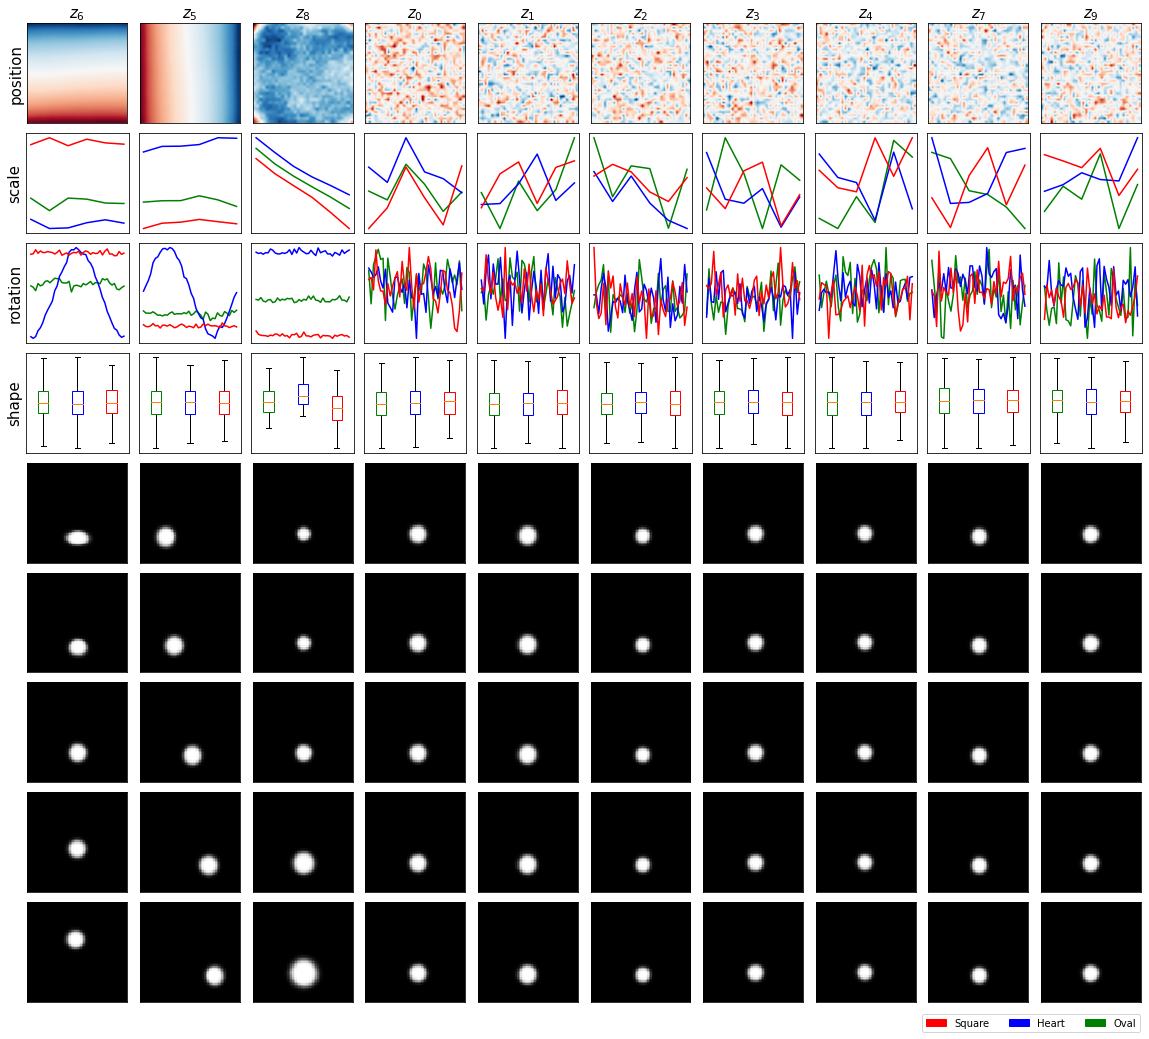

In [0]:
show_latents(vae10, dims=[6, 5, 8, 0, 1, 2, 3, 4, 7, 9], ds=ds, reconstruction_activation_function=tf.nn.sigmoid, save='vae10_latent_discovery.pdf')
# no latent responsible for encoding rotation!

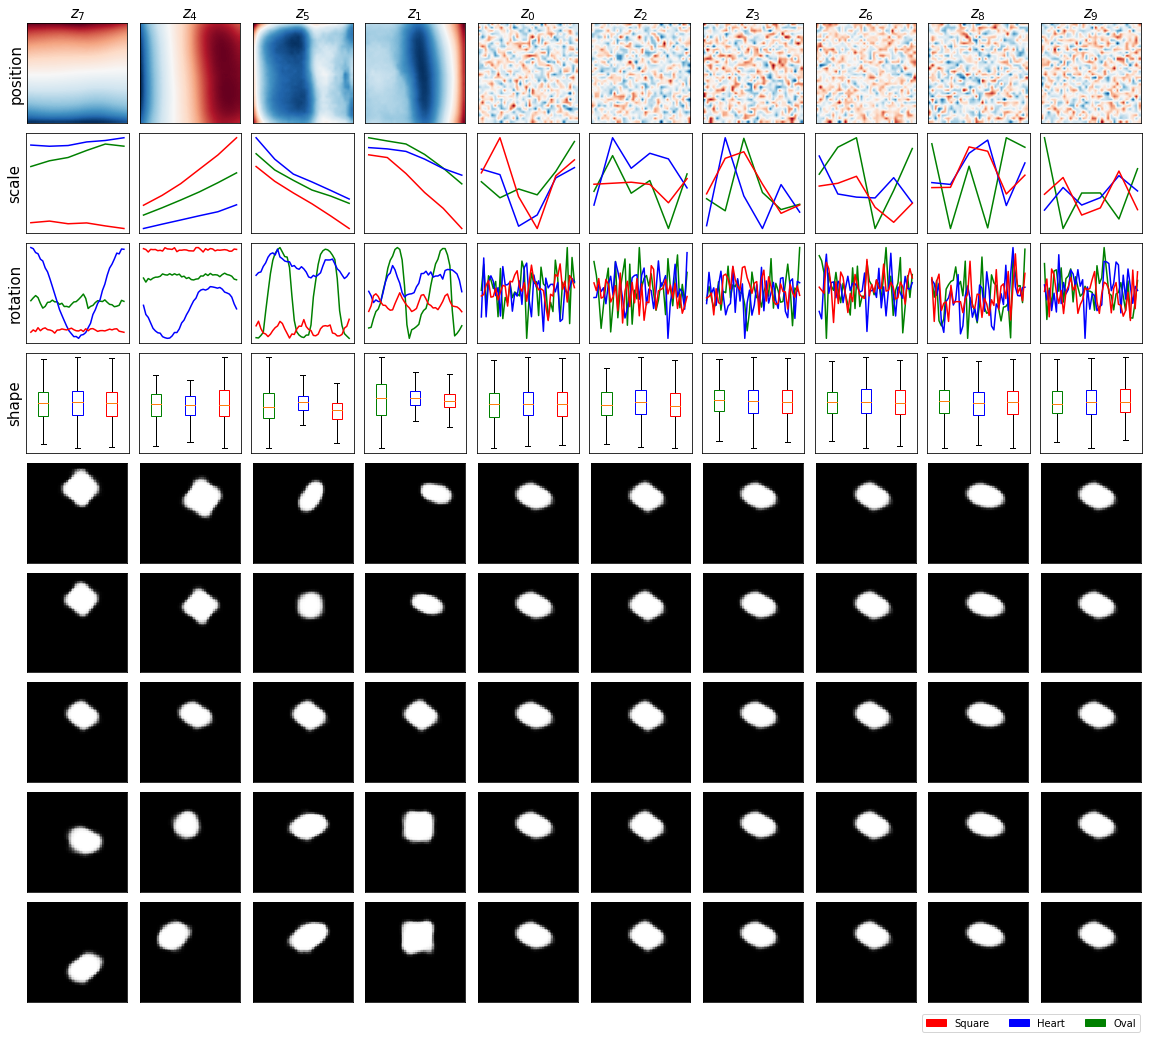

In [0]:
show_latents(vae5, dims=[7, 4, 5, 1, 0, 2, 3, 6, 8, 9], ds=ds, reconstruction_activation_function=tf.nn.sigmoid, save='vae5_latent_discovery.pdf')

* dim 1 and dim 4 both encode x-coord
* dim 1 and dim 5 also encode rotation
* dim 1, 4, 5 encode scale.